In [1]:
from PIL import Image
import sam3
from sam3.train.data.collator import collate_fn_api as collate
from sam3.model.utils.misc import copy_data_to_device
import os
sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")

In [2]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook. If your card doesn't support it, try float16 instead
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# inference mode for the whole notebook. Disable if you need gradients
torch.inference_mode().__enter__()

In [3]:
import sys

sys.path.append(f"{sam3_root}/examples")

from sam3.visualization_utils import plot_results

In [4]:
from sam3.train.data.sam3_image_dataset import InferenceMetadata, FindQueryLoaded, Image as SAMImage, Datapoint
from typing import List

GLOBAL_COUNTER = 1
def create_empty_datapoint():
    """ A datapoint is a single image on which we can apply several queries at once. """
    return Datapoint(find_queries=[], images=[])

def set_image(datapoint, pil_image):
    """ Add the image to be processed to the datapoint """
    w,h = pil_image.size
    datapoint.images = [SAMImage(data=pil_image, objects=[], size=[h,w])]

def add_text_prompt(datapoint, text_query):
    """ Add a text query to the datapoint """

    global GLOBAL_COUNTER
    # in this function, we require that the image is already set.
    # that's because we'll get its size to figure out what dimension to resize masks and boxes
    # In practice you're free to set any size you want, just edit the rest of the function
    assert len(datapoint.images) == 1, "please set the image first"

    w, h = datapoint.images[0].size
    datapoint.find_queries.append(
        FindQueryLoaded(
            query_text=text_query,
            image_id=0,
            object_ids_output=[], # unused for inference
            is_exhaustive=True, # unused for inference
            query_processing_order=0,
            inference_metadata=InferenceMetadata(
                coco_image_id=GLOBAL_COUNTER,
                original_image_id=GLOBAL_COUNTER,
                original_category_id=1,
                original_size=[w, h],
                object_id=0,
                frame_index=0,
            )
        )
    )
    GLOBAL_COUNTER += 1
    return GLOBAL_COUNTER - 1

def add_visual_prompt(datapoint, boxes:List[List[float]], labels:List[bool], text_prompt="visual"):
    """ Add a visual query to the datapoint.
    The bboxes are expected in XYXY format (top left and bottom right corners)
    For each bbox, we expect a label (true or false). The model tries to find boxes that ressemble the positive ones while avoiding the negative ones
    We can also give a text_prompt as an additional hint. It's not mandatory, leave it to "visual" if you want the model to solely rely on the boxes.

    Note that the model expects the prompt to be consistent. If the text reads "elephant" but the provided boxe points to a dog, the results will be undefined.
    """

    global GLOBAL_COUNTER
    # in this function, we require that the image is already set.
    # that's because we'll get its size to figure out what dimension to resize masks and boxes
    # In practice you're free to set any size you want, just edit the rest of the function
    assert len(datapoint.images) == 1, "please set the image first"
    assert len(boxes) > 0, "please provide at least one box"
    assert len(boxes) == len(labels), f"Expecting one label per box. Found {len(boxes)} boxes but {len(labels)} labels"
    for b in boxes:
        assert len(b) == 4, f"Boxes must have 4 coordinates, found {len(b)}"

    labels = torch.tensor(labels, dtype=torch.bool).view(-1)
    if not labels.any().item() and text_prompt=="visual":
        print("Warning: you provided no positive box, nor any text prompt. The prompt is ambiguous and the results will be undefined")
    w, h = datapoint.images[0].size
    datapoint.find_queries.append(
        FindQueryLoaded(
            query_text=text_prompt,
            image_id=0,
            object_ids_output=[], # unused for inference
            is_exhaustive=True, # unused for inference
            query_processing_order=0,
            input_bbox=torch.tensor(boxes, dtype=torch.float).view(-1,4),
            input_bbox_label=labels,
            inference_metadata=InferenceMetadata(
                coco_image_id=GLOBAL_COUNTER,
                original_image_id=GLOBAL_COUNTER,
                original_category_id=1,
                original_size=[w, h],
                object_id=0,
                frame_index=0,
            )
        )
    )
    GLOBAL_COUNTER += 1
    return GLOBAL_COUNTER - 1

In [5]:
from sam3 import build_sam3_image_model

bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path)

In [6]:
from sam3.train.transforms.basic_for_api import ComposeAPI, RandomResizeAPI, ToTensorAPI, NormalizeAPI

from sam3.model.position_encoding import PositionEmbeddingSine
transform = ComposeAPI(
    transforms=[
        RandomResizeAPI(sizes=1008, max_size=1008, square=True, consistent_transform=False),
        ToTensorAPI(),
        NormalizeAPI(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)


In [ ]:
from sam3.eval.postprocessors import PostProcessImage
postprocessor = PostProcessImage(
    max_dets_per_img=-1,       # if this number is positive, the processor will return topk. For this demo we instead limit by confidence, see below
    iou_type="segm",           # we want masks
    use_original_sizes_box=True,   # our boxes should be resized to the image size
    use_original_sizes_mask=True,   # our masks should be resized to the image size
    convert_mask_to_rle=False, # the postprocessor supports efficient conversion to RLE format. In this demo we prefer the binary format for easy plotting
    detection_threshold=0.5,   # Only return confident detections
    to_cpu=False,
)

In [8]:
# "video_path" needs to be either a JPEG folder or a MP4 video file
# vCai6dwL1CzXj0bpF1U7
video_id = "82CSyVHJ8ViXguPHf7ba"
video_path = f"/data/engine_reite_results/{video_id}/ext_top/frames"
frame_id = 0

In [9]:
import glob
frame_paths = glob.glob(os.path.join(video_path, "*"))

In [ ]:
batches_list = []
for fdx, frame in enumerate(frame_paths):
    img = Image.open(frame)
    datapoint = create_empty_datapoint()
    set_image(datapoint, img)
    id1 = add_text_prompt(datapoint, "right hand")
    id2 = add_text_prompt(datapoint, "left hand")
    id3 = add_text_prompt(datapoint, "cellphone")
    id4 = add_text_prompt(datapoint, "small object")

    datapoint = transform(datapoint)
    batches_list.append(datapoint)

In [11]:
import tqdm
import time

batch_size = 1
final_results = []
start = time.time()
for bdx in tqdm.tqdm(range(0, len(batches_list), batch_size)):
    batch = collate(batches_list[bdx:bdx+batch_size], dict_key="dummy")["dummy"]
    batch = copy_data_to_device(batch, torch.device("cuda"), non_blocking=True)
    output = model(batch)
    processed_results = postprocessor.process_results(output, batch.find_metadatas)
    final_results.append(processed_results)
    del batch
    del output
    torch.cuda.empty_cache()
print(f"Processing time: {time.time() - start} s")

100%|██████████| 316/316 [02:03<00:00,  2.56it/s]

Processing time: 123.54116153717041 s


found 0 object(s)


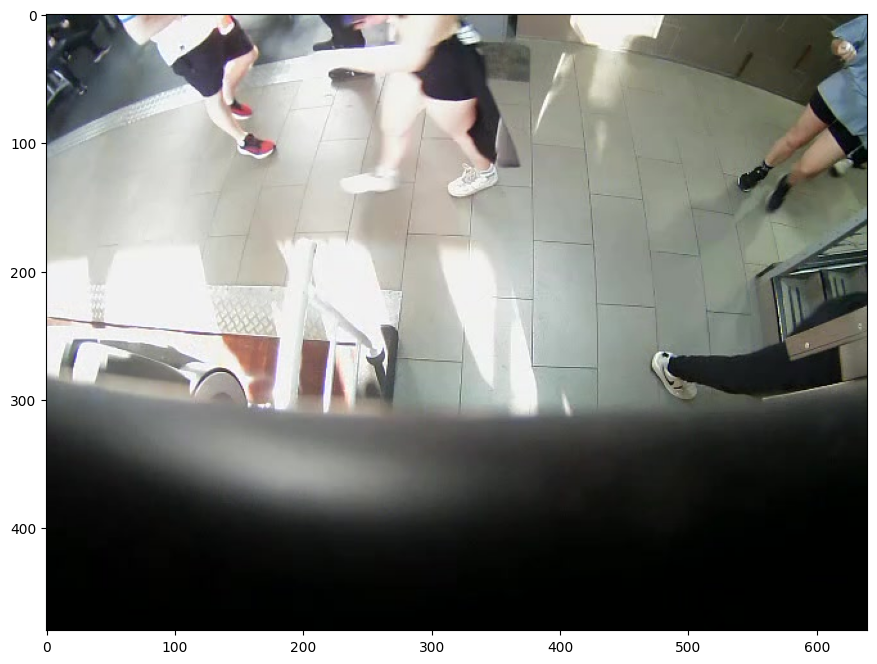

In [26]:
for fdx, frame in enumerate(frame_paths):
    if fdx != 250: 
        continue
    img = Image.open(frame)
    local_keys = list(final_results[fdx].keys())
    selected_key = local_keys[0]
    plot_results(img, final_results[fdx][selected_key])
    break